In [233]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Data

In [234]:
data_train = pd.read_csv('../data/landmark_train.csv', header = None)
data_train.rename(columns={0: 'class'}, inplace=True)

data_val = pd.read_csv('../data/landmark_val.csv', header = None)
data_val.rename(columns={0: 'class'}, inplace=True)

data_test = pd.read_csv('../data/landmark_test.csv', header = None)
data_test.rename(columns={0: 'class'}, inplace=True)

In [235]:
data_train.head()

,class,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1,0.737817,0.952539,-3.422762e-07,0.679783,0.910816,-0.040841,0.638355,0.798009,-0.067538,...,-0.079880,0.812031,0.786412,-0.110996,0.777773,0.853772,-0.109390,0.756940,0.840830,-0.103323
1,1,0.737788,0.949083,-3.280368e-07,0.679917,0.908141,-0.040232,0.638414,0.794934,-0.066173,...,-0.077981,0.809808,0.787309,-0.108219,0.775743,0.852140,-0.106052,0.755859,0.839046,-0.099421
2,1,0.740318,0.952811,-3.727930e-07,0.680487,0.912496,-0.040986,0.638046,0.801638,-0.068100,...,-0.079770,0.816616,0.784904,-0.111412,0.782650,0.853981,-0.109616,0.760015,0.842810,-0.103190
3,1,0.736159,0.958327,-3.369044e-07,0.677534,0.917838,-0.043093,0.635010,0.810609,-0.072415,...,-0.083434,0.813695,0.791525,-0.114416,0.779570,0.860431,-0.111203,0.757949,0.846861,-0.103791
4,1,0.736295,0.961405,-2.995568e-07,0.677813,0.919901,-0.039999,0.633051,0.815260,-0.067304,...,-0.081325,0.801587,0.814893,-0.110820,0.769165,0.876808,-0.107950,0.753947,0.866378,-0.100151


In [236]:
data_train['class'].value_counts()
# Balanced dataset

class
4    270
3    265
1    238
0    227
2    224
Name: count, dtype: int64

In [237]:
# Convert dataframe to array
X_train = data_train.iloc[:, 1:].values
y_train = data_train.iloc[:, 0].values

X_val = data_val.iloc[:, 1:].values
y_val = data_val.iloc[:, 0].values

X_test = data_test.iloc[:, 1:].values
y_test = data_test.iloc[:, 0].values

In [238]:
X_train.shape, y_train.shape

((1224, 63), (1224,))

# Normalize data

In [239]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((1224, 63), (422, 63), (453, 63), (1224,), (422,), (453,))

In [240]:
# Convert nparray to tensor because torch only accepts tensor and we need to use neural network
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Build DataLoader

In [241]:
batch_size = 64

In [242]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
        
training_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)
val_data = CustomDataset(X_val, y_val)

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Build MLP Model - ThuyDuc Ver

In [243]:
from typing import Literal, Optional
import math
import random
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_layer, output_size):
        super().__init__()
        
        # Set up layers
        layers = [
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(0.1)
        ]
        
        for _ in range(hidden_layer - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.LeakyReLU(0.1))
        
        layers.append(nn.Linear(hidden_size, output_size))

        self.classifier = nn.Sequential(*layers)
        
        # # Initialize weights
        # for layer in self.classifier:
        #     if isinstance(layer, nn.Linear):
        #         nn.init.xavier_uniform_(layer.weight)
        #         if layer.bias is not None:
        #             nn.init.zeros_(layer.bias)

        # Initialize weights
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')  # or 'leaky_relu'
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
    
    def forward(self, X):
        output = self.classifier(X)
        return output

# Training Session

In [244]:
train_lossess = []
val_lossess = []
f1_train = []
f1_val = []

In [245]:
epochs = 300

input_size = X_train.shape[1]
hidden_size = 256
hidden_layer = 3
output_size = len(torch.unique(y_train))
model = NeuralNetwork(input_size, hidden_size, hidden_layer, output_size)

lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()
model

NeuralNetwork(
  (classifier): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=256, out_features=5, bias=True)
  )
)

In [246]:
best_f1_val = 0.0
best_model_state = None

train_lossess = []
val_lossess = []
f1_train = []
f1_val = []

for epoch in range(epochs):
    train_loss = 0
    val_loss = 0

    y_train_label_pred = []
    y_train_label_true = []

    y_val_label_pred = []
    y_val_label_true = []

    # Training session
    model.train()
    for X_train, y_train in train_loader:
        optimizer.zero_grad()  # Reset gradients

        # Forward pass
        y_pred = model(X_train)

        # Compute loss
        loss = criterion(y_pred, y_train)
        train_loss += loss.item()

        # Predictions
        y_train_label_true.extend(y_train.tolist())
        y_train_label_pred.extend(torch.argmax(y_pred, dim=1).tolist())

        # Backpropagation
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_lossess.append(train_loss)

    f1_score_train = f1_score(y_train_label_true, y_train_label_pred, average='macro')
    f1_train.append(f1_score_train)

    # Validation session
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            val_loss += loss.item()

            y_val_label_true.extend(y_val.tolist())
            y_val_label_pred.extend(torch.argmax(y_pred, dim=1).tolist())

        val_loss /= len(val_loader)
        val_lossess.append(val_loss)

        f1_score_val = f1_score(y_val_label_true, y_val_label_pred, average='macro')
        f1_val.append(f1_score_val)

        # Save best model based on validation F1 score
        if f1_score_val > best_f1_val:
            best_f1_val = f1_score_val
            best_model_state = model.state_dict()
            print(f"Epoch {epoch+1}: New best F1 on val = {f1_score_val:.4f}, saving model...")

# After training, save the best model weights to a file
torch.save(best_model_state, 'best_model.pth')
print("Training complete. Best model saved as 'best_model.pth'")

Epoch 1: New best F1 on val = 0.6556, saving model...
Epoch 2: New best F1 on val = 0.7467, saving model...
Epoch 3: New best F1 on val = 0.8008, saving model...
Epoch 5: New best F1 on val = 0.8339, saving model...
Epoch 6: New best F1 on val = 0.8400, saving model...
Epoch 8: New best F1 on val = 0.8539, saving model...
Epoch 9: New best F1 on val = 0.8699, saving model...
Epoch 15: New best F1 on val = 0.8755, saving model...
Epoch 19: New best F1 on val = 0.8890, saving model...
Epoch 34: New best F1 on val = 0.8895, saving model...
Epoch 35: New best F1 on val = 0.8916, saving model...
Epoch 53: New best F1 on val = 0.8917, saving model...
Epoch 54: New best F1 on val = 0.8921, saving model...
Epoch 64: New best F1 on val = 0.8940, saving model...
Epoch 65: New best F1 on val = 0.8943, saving model...
Epoch 72: New best F1 on val = 0.8964, saving model...
Epoch 89: New best F1 on val = 0.9003, saving model...
Epoch 188: New best F1 on val = 0.9006, saving model...
Epoch 194: New b

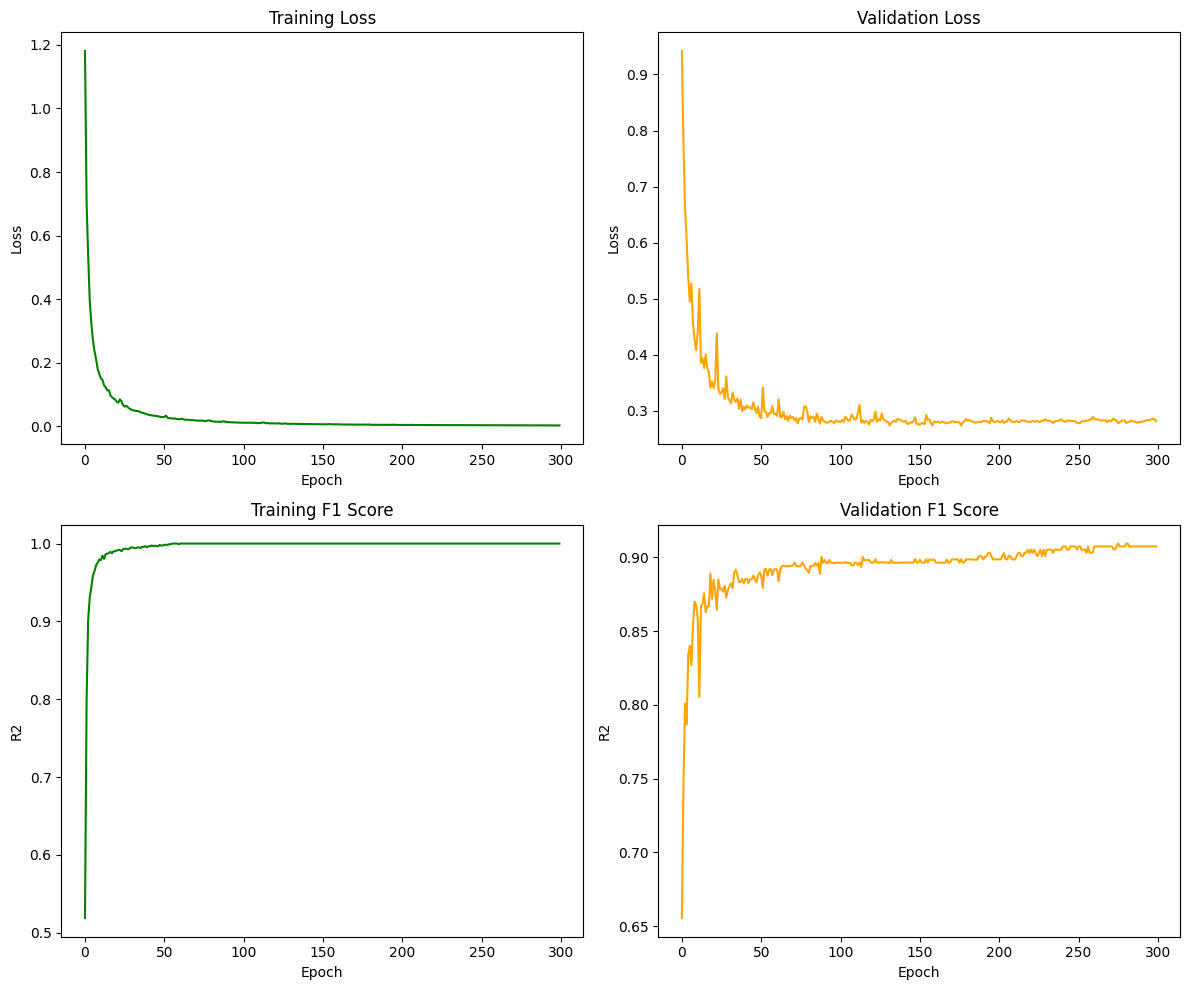

In [247]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_lossess, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_lossess, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(f1_train, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='R2')
ax[1, 0].set_title('Training F1 Score')

ax[1, 1].plot(f1_val, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='R2')
ax[1, 1].set_title('Validation F1 Score')
plt.tight_layout()

plt.show()

# Evaluation

In [249]:
best_model_state = torch.load('best_model.pth', map_location=torch.device('cpu'))
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [252]:
model.eval()
y_test_label_true = []
y_test_label_pred = []
test_loss = 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        # forward pass
        y_pred = model(X_test)

        # calculate loss
        loss = criterion(y_pred, y_test)
        test_loss += loss.item()

        # concat
        y_test_label_true.extend(y_test.tolist())
        y_test_label_pred.extend(torch.argmax(y_pred, dim=1).tolist())

    test_loss /= len(test_loader)


    f1_score = f1_score(y_test_label_true, y_test_label_pred, average='macro')

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {f1_score:.4f}')

Test Loss: 0.2816
Test Accuracy: 0.9072
